Mount teh google drive for dataset and source files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Utility functions

In [ ]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])

        token_sequences.append(token_sequence)

    return token_sequences

def get_words(sentences):
    words = set([])
    for sentence in sentences:
        for word in sentence:
            words.add(word)
    return words

def get_tags(sentences_tags):
    tags = set([])
    for tag in sentences_tags:
        for t in tag:
            tags.add(t)
    return tags

def get_train_sentences_x(train_sentences, word2index):
    train_sentences_x = []
    for sentence in train_sentences:
        sentence_index = []
        for word in sentence:
            try:
                sentence_index.append(word2index[word])
            except KeyError:
                sentence_index.append(word2index['-OOV-'])

        train_sentences_x.append(sentence_index)
    return train_sentences_x

def get_test_sentences_x(test_sentences, word2index):
    test_sentences_x = []
    for sentence in test_sentences:
        sentence_index = []
        for word in sentence:
            try:
                sentence_index.append(word2index[word])
            except KeyError:
                sentence_index.append(word2index['-OOV-'])
        test_sentences_x.append(sentence_index)
    return test_sentences_x

def get_train_tags_y(train_tags, tag2index):
    train_tags_y = []
    for tags in train_tags:
        train_tags_y.append([tag2index[t] for t in tags])
    return train_tags_y

def get_test_tags_y(test_tags, tag2index):
    test_tags_y = []
    for tags in test_tags:
        test_tags_y.append([tag2index[t] for t in tags])
    return test_tags_y

Train the model 

In [ ]:
import ast
import codecs
import json
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense, InputLayer, Embedding, Activation, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


tagged_sentences = codecs.open("/content/drive/My Drive/Urdu-NLP/urdu-ner-lstm/corpus.txt", encoding="utf-8").readlines()

print(tagged_sentences[0])
print("Tagged sentences: ", len(tagged_sentences))

sentences, sentence_tags = [], []
for tagged_sentence in tagged_sentences:
    sentence, tags = zip(*ast.literal_eval(tagged_sentence))
    sentences.append(np.array(sentence))
    sentence_tags.append(np.array(tags))

(train_sentences,
 test_sentences,
 train_tags,
 test_tags) = train_test_split(sentences, sentence_tags, test_size=0.2)

words = get_words(sentences)
tags = get_tags(sentence_tags)

word2index = {w: i + 2 for i, w in enumerate(list(words))}
word2index['-PAD-'] = 0
word2index['-OOV-'] = 1

tag2index = {t: i + 1 for i, t in enumerate(list(tags))}
tag2index['-PAD-'] = 0

train_sentences_x = get_train_sentences_x(train_sentences, word2index)
test_sentences_x = get_test_sentences_x(test_sentences, word2index)

train_tags_y = get_train_tags_y(train_tags, tag2index)
test_tags_y = get_test_tags_y(test_tags, tag2index)

MAX_LENGTH = len(max(train_sentences_x, key=len))
# MAX_LENGTH = 181

train_sentences_x = pad_sequences(train_sentences_x, maxlen=MAX_LENGTH, padding='post')
test_sentences_x = pad_sequences(test_sentences_x, maxlen=MAX_LENGTH, padding='post')
train_tags_y = pad_sequences(train_tags_y, maxlen=MAX_LENGTH, padding='post')
test_tags_y = pad_sequences(test_tags_y, maxlen=MAX_LENGTH, padding='post')

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH,)))
model.add(Embedding(len(word2index), 128))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(len(tag2index)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
history = model.fit(train_sentences_x, to_categorical(train_tags_y, len(tag2index)), batch_size=32, epochs=10,
                    validation_split=0.2).history
# model.save("../models/lstm_ner.h5")
model.summary()

scores = model.evaluate(test_sentences_x, to_categorical(test_tags_y, len(tag2index)))
print(f"{model.metrics_names[1]}: {scores[1] * 100}")  # acc: 98.39311069478103
print(test_sentences[0])
print(test_tags[0])
test_samples = [
    test_sentences[0],
]

test_samples_x = []
for sentence in test_samples:
    sentence_index = []
    for word in sentence:
        try:
            sentence_index.append(word2index[word])
        except KeyError:
            sentence_index.append(word2index['-OOV-'])
    test_samples_x.append(sentence_index)

test_samples_X = pad_sequences(test_samples_x, maxlen=MAX_LENGTH, padding='post')

predictions = model.predict(test_samples_X)
print(logits_to_tokens(predictions, {i: t for t, i in tag2index.items()}))


[('کولمبو', 'U-LOCATION'), ('ٹیسٹ', 'O'), ('کے', 'O'), ('دوسرے', 'U-NUMBER'), ('روز', 'O'), ('سری', 'B-PERSON'), ('لنکن', 'I-PERSON'), ('ٹیم', 'L-PERSON'), ('پاکستان', 'U-LOCATION'), ('کے', 'O'), ('138', 'U-NUMBER'), ('رنز', 'O'), ('کے', 'O'), ('جواب', 'O'), ('میں', 'O'), ('اپنی', 'O'), ('پہلی', 'U-NUMBER'), ('اننگز', 'O'), ('میں', 'O'), ('315', 'U-NUMBER'), ('رنز', 'O'), ('بنا', 'O'), ('کر', 'O'), ('آؤٹ', 'O'), ('ہو', 'O'), ('گئی', 'O'), ('ہے', 'O'), ('۔', 'O')]

Tagged sentences:  123753


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79201 samples, validate on 19801 samples
Epoch 1/10
79201/79201 [==============================] - 346s 4ms/step - loss: 0.0874 - accuracy: 0.9812 - val_loss: 0.0066 - val_accuracy: 0.9984
Epoch 2/10
79201/79201 [==============================] - 360s 5ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 0.9992
Epoch 3/10
79201/79201 [==============================] - 358s 5ms/step - loss: 0.0022 - accuracy: 0.9992 - val_loss: 0.0017 - val_accuracy: 0.9993
Epoch 4/10
79201/79201 [==============================] - 359s 5ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9993
Epoch 5/10
79201/79201 [==============================] - 360s 5ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0016 - val_accuracy: 0.9991
Epoch 6/10
79201/79201 [==============================] - 359s 5ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0015 - val_accuracy: 0.9993
Epoch 7/10
79201/79201 [==============================] - 363s

Plot it

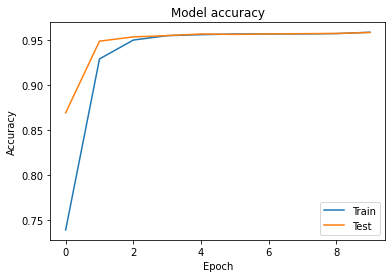

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
# plt.savefig("../results/accuracy_lstm_ner.png")


accuracy

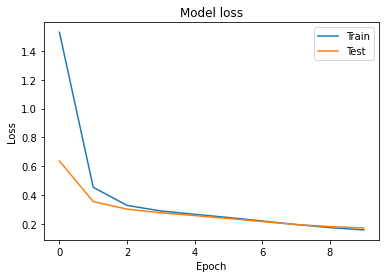

In [ ]:
plt.clf()

# Plot training & validation loss values
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
# plt.savefig("../results/loss_lstm_ner.png")